In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline
#ACP
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [2]:
#Chargement des données
epl_df = pd.read_csv('data/EPL_20_21(1).csv')
epl_df

,Name,Club,Nationality,Position,Age,Matches,Starts,Mins,Goals,Assists,Passes_Attempted,Perc_Passes_Completed,Penalty_Goals,Penalty_Attempted,xG,xA,Yellow_Cards,Red_Cards,Clean_Sheet
0,Mason Mount,Chelsea,ENG,"MF,FW",21,36,32,2890,6,5,1881,82.3,1,1,0.21,0.24,2,0,16
1,Edouard Mendy,Chelsea,SEN,GK,28,31,31,2745,0,0,1007,84.6,0,0,0.00,0.00,2,0,16
2,Timo Werner,Chelsea,GER,FW,24,35,29,2602,6,8,826,77.2,0,0,0.41,0.21,2,0,16
3,Ben Chilwell,Chelsea,ENG,DF,23,27,27,2286,3,5,1806,78.6,0,0,0.10,0.11,3,0,16
4,Reece James,Chelsea,ENG,DF,20,32,25,2373,1,2,1987,85.0,0,0,0.06,0.12,3,0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,Lys Mousset,Sheffield United,FRA,"FW,MF",24,11,2,296,0,0,50,80.0,0,0,0.22,0.10,0,0,5
528,Jack O'Connell,Sheffield United,ENG,DF,26,2,2,180,0,0,77,77.9,0,0,0.00,0.00,0,0,5
529,Iliman Ndiaye,Sheffield United,FRA,MF,21,1,0,12,0,0,3,100.0,0,0,0.00,0.00,0,0,5
530,Antwoine Hackford,Sheffield United,ENG,"DF,FW",16,1,0,11,0,0,1,100.0,0,0,1.16,0.00,0,0,5


In [3]:
#Correction de la position des joueurs
epl_df["Position"] =  epl_df["Position"].str[:2]

In [4]:
#Ajout des colonnes generee
#Nombre moyen de but marquéé par matche
epl_df['GoalsPerMatch'] = (epl_df['Goals']/epl_df['Matches']).astype(float)
#Nombre moyen de minutes jouee par matche
epl_df['MinsPerMatch'] = (epl_df['Mins']/epl_df['Matches']).astype(int)
#Points de performance "Fantasy"
epl_df['PointsOfFantasy'] = epl_df['Goals']*4 + epl_df['Assists']*3 + epl_df['Matches']*1 + epl_df['Clean_Sheet']*2 - epl_df['Yellow_Cards'] - epl_df['Red_Cards']*3 -(epl_df['Penalty_Attempted']-epl_df['Penalty_Goals'])*2 + epl_df['Penalty_Goals']
#classification par performance manuellement
Performance_Cat = []
for pts in epl_df["PointsOfFantasy"].astype(int):
    if pts >= 100:
        Performance_Cat.append("Top")
    elif pts >= 50:
        Performance_Cat.append("Avg")
    else:
        Performance_Cat.append("Low")

epl_df["Performance_Cat"] = Performance_Cat
#classification par joueur locale et externe
local_foreign = []
for nat in epl_df["Nationality"]:
    if nat == 'ENG':
        local_foreign.append("Local")
    else:
        local_foreign.append("Foreign")

epl_df["Local_Foreign"] = local_foreign
#classification par age
Age_Cat = []
for cat in epl_df["Age"].astype(int):
    if cat < 20:
        Age_Cat.append("Under20")
    elif cat >= 20 and cat <25:
        Age_Cat.append("20-25")    
    elif cat >= 25 and cat <30:
        Age_Cat.append("25-30")
    else:
        Age_Cat.append("Over30")

epl_df["Age_Cat"] = Age_Cat

epl_df.head()

,Name,Club,Nationality,Position,Age,Matches,Starts,Mins,Goals,Assists,...,xA,Yellow_Cards,Red_Cards,Clean_Sheet,GoalsPerMatch,MinsPerMatch,PointsOfFantasy,Performance_Cat,Local_Foreign,Age_Cat
0,Mason Mount,Chelsea,ENG,MF,21,36,32,2890,6,5,...,0.24,2,0,16,0.166667,80,106,Top,Local,20-25
1,Edouard Mendy,Chelsea,SEN,GK,28,31,31,2745,0,0,...,0.00,2,0,16,0.000000,88,61,Avg,Foreign,25-30
2,Timo Werner,Chelsea,GER,FW,24,35,29,2602,6,8,...,0.21,2,0,16,0.171429,74,113,Top,Foreign,20-25
3,Ben Chilwell,Chelsea,ENG,DF,23,27,27,2286,3,5,...,0.11,3,0,16,0.111111,84,83,Avg,Local,20-25
4,Reece James,Chelsea,ENG,DF,20,32,25,2373,1,2,...,0.12,3,0,16,0.031250,74,71,Avg,Local,20-25


In [5]:
#Information sur les donnees
epl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   532 non-null    object 
 1   Club                   532 non-null    object 
 2   Nationality            532 non-null    object 
 3   Position               532 non-null    object 
 4   Age                    532 non-null    int64  
 5   Matches                532 non-null    int64  
 6   Starts                 532 non-null    int64  
 7   Mins                   532 non-null    int64  
 8   Goals                  532 non-null    int64  
 9   Assists                532 non-null    int64  
 10  Passes_Attempted       532 non-null    int64  
 11  Perc_Passes_Completed  532 non-null    float64
 12  Penalty_Goals          532 non-null    int64  
 13  Penalty_Attempted      532 non-null    int64  
 14  xG                     532 non-null    float64
 15  xA    

In [6]:
#Description des donnees
epl_df.describe()

,Age,Matches,Starts,Mins,Goals,Assists,Passes_Attempted,Perc_Passes_Completed,Penalty_Goals,Penalty_Attempted,xG,xA,Yellow_Cards,Red_Cards,Clean_Sheet,GoalsPerMatch,MinsPerMatch,PointsOfFantasy
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,25.500000,19.535714,15.714286,1411.443609,1.853383,1.287594,717.750000,77.823872,0.191729,0.234962,0.113289,0.072650,2.114662,0.090226,10.077068,0.072531,63.607143,48.686090
std,4.319404,11.840459,11.921161,1043.171856,3.338009,2.095191,631.372522,13.011631,0.850881,0.975818,0.148174,0.090072,2.269094,0.293268,3.431833,0.116598,25.001879,27.274105
min,16.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.000000,9.000000
25%,22.000000,9.000000,4.000000,426.000000,0.000000,0.000000,171.500000,73.500000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,8.000000,0.000000,49.000000,28.000000
50%,26.000000,21.000000,15.000000,1345.000000,1.000000,0.000000,573.500000,79.200000,0.000000,0.000000,0.060000,0.050000,2.000000,0.000000,10.000000,0.027778,71.000000,43.000000
75%,29.000000,30.000000,27.000000,2303.500000,2.000000,2.000000,1129.500000,84.625000,0.000000,0.000000,0.150000,0.110000,3.000000,0.000000,11.000000,0.091991,84.000000,60.000000
max,38.000000,38.000000,38.000000,3420.000000,23.000000,14.000000,3214.000000,100.000000,9.000000,10.000000,1.160000,0.900000,12.000000,2.000000,19.000000,0.657143,90.000000,196.000000


<AxesSubplot:>

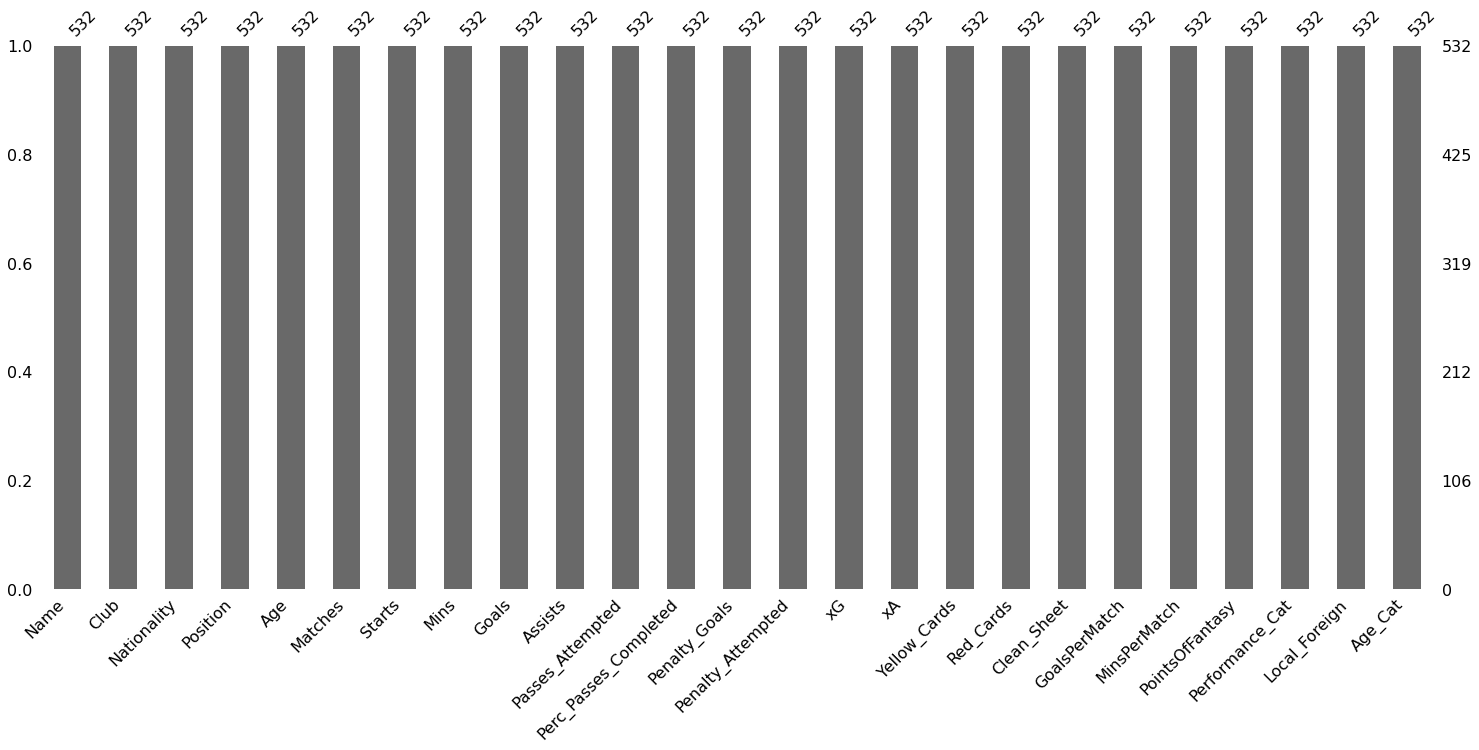

In [7]:
#Graphe des valeurs null
msno.bar(epl_df)

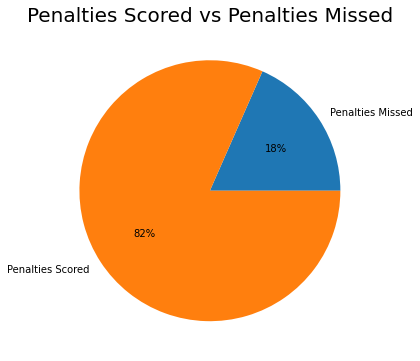

In [8]:
#Graph de niveau de perte des penalties
total_goals = epl_df['Goals'].sum()
total_penalty_attempted = epl_df['Penalty_Attempted'].sum()
total_penalty_goals = epl_df['Penalty_Goals'].sum()
plt.figure(figsize=(13, 6))
penalty_not_scored = total_penalty_attempted - total_penalty_goals
data = [penalty_not_scored, total_penalty_goals]
labels = ['Penalties Missed', 'Penalties Scored']
colors = sns.color_palette()
plt.title('Penalties Scored vs Penalties Missed', fontsize = 20)
plt.pie(data, labels = labels, colors = colors, autopct = '%.0f%%')
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

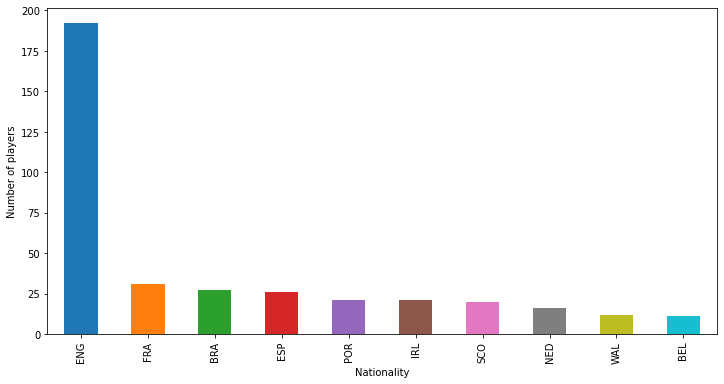

In [9]:
#Graph des nationnalités domminants dans la premier league
nationality = epl_df.groupby('Nationality').size().sort_values(ascending = False)
head = nationality.head(10)
ax = head.plot(kind='bar', figsize=(12, 6),xlabel='Nationality', ylabel='Number of players', color = sns.color_palette())
ax.bar_label(ax.containers[0], label_type='edge')
plt.title('Most 10 nationality in premier league', fontsize = 20)
plt.show()

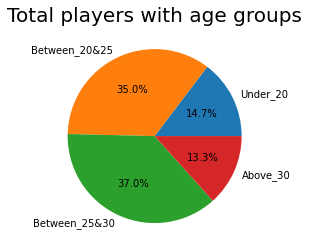

In [10]:
#Graphe de distribution d'age en premier league
players_under_20 = epl_df[epl_df['Age'] <= 20]
plyayers_between_20_25 = epl_df[(epl_df['Age'] > 20) & (epl_df['Age'] <= 25)]
players_between_25_30 = epl_df[(epl_df['Age'] > 25) & (epl_df['Age'] <= 30)]
players_above_30 = epl_df[epl_df['Age'] > 30]
x = np.array([players_under_20['Name'].count(), plyayers_between_20_25['Name'].count(), players_between_25_30['Name'].count(), players_above_30['Name'].count()])
myLabels = ['Under_20','Between_20&25','Between_25&30','Above_30']
plt.title('Total players with age groups', fontsize = 20)
plt.pie(x, labels = myLabels, autopct = '%.1f%%')
plt.show()

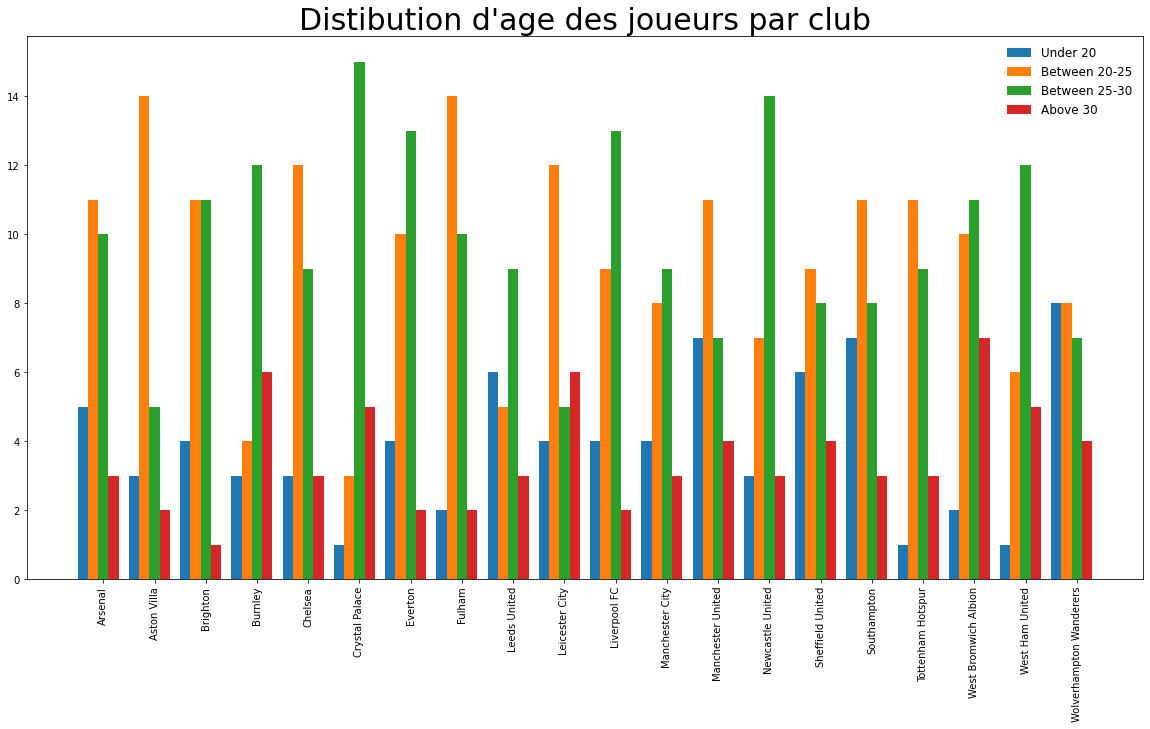

In [11]:
#Graphe de distibution d'age par club
x1 = players_under_20[['Age', 'Club']].groupby('Club').count()['Age']
x2 = plyayers_between_20_25[['Age', 'Club']].groupby('Club').count()['Age']
x3 = players_between_25_30[['Age', 'Club']].groupby('Club').count()['Age']
x4 = players_above_30[['Age', 'Club']].groupby('Club').count()['Age']
clubs = players_under_20[['Age', 'Club']].groupby('Club').count().index

fig, ax = plt.subplots(figsize=(20, 10))

X_axis = np.arange(len(clubs))
plt.bar(X_axis - 0.4, x1, 0.2, label = "Under 20")
plt.bar(X_axis - 0.2, x2, 0.2,label = "Between 20-25")
plt.bar(X_axis, x3, 0.2, label = "Between 25-30")
plt.bar(X_axis + 0.2, x4, 0.2,label = "Above 30")

plt.xticks(X_axis, clubs, rotation = 90)
plt.title('Distibution d\'age des joueurs par club', fontsize = 30)

#for index, data in enumerate(x1):
#    plt.text(x=index , y=data/2 , s=f"{data}" , fontdict=dict(fontsize=14), horizontalalignment='center')
#for index, data in enumerate(x2):
#    plt.text(x=index , y= x1[index] + ((data -x1[index]) /2) , s=f"{data - x1[index]}" , fontdict=dict(fontsize=14), horizontalalignment='center')
#for index, data in enumerate(x3):
#    plt.text(x=index , y= x2[index] + ((data -x2[index]) /2) , s=f"{data -x2[index]}" , fontdict=dict(fontsize=14), horizontalalignment='center')
#for index, data in enumerate(x4):
#    plt.text(x=index , y= data + ((data -x3[index]) /2) , s=f"{data -x3[index]}" , fontdict=dict(fontsize=14), horizontalalignment='center')
ax.legend(fontsize=12, frameon=False)


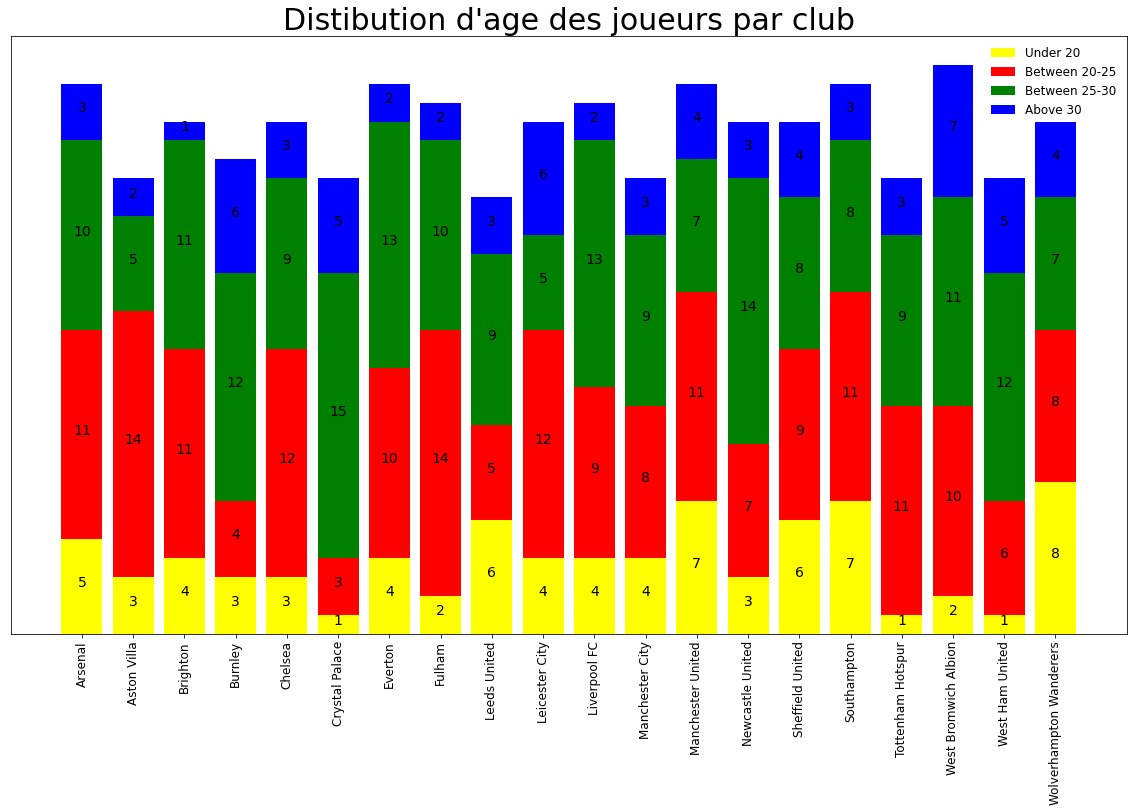

In [12]:
#Graphe de distibution d'age par club
x1 = players_under_20[['Age', 'Club']].groupby('Club').count()['Age']
x2 = plyayers_between_20_25[['Age', 'Club']].groupby('Club').count()['Age'] + x1
x3 = players_between_25_30[['Age', 'Club']].groupby('Club').count()['Age'] + x2
x4 = players_above_30[['Age', 'Club']].groupby('Club').count()['Age'] + x3
clubs = players_under_20[['Age', 'Club']].groupby('Club').count().index

fig, ax = plt.subplots(figsize=(20, 11))

ax.bar(clubs, x1, label = "Under 20", color='yellow')
ax.bar(clubs, x2 - x1,bottom= x1,label = "Between 20-25", color='r')
ax.bar(clubs, x3 - x2,bottom= x2, label = "Between 25-30",color='g')
ax.bar(clubs, x4 - x3,bottom= x3,label = "Above 30", color='b')

plt.xticks(clubs,rotation = 90, fontsize=12)
plt.yticks(np.arange(32,30), fontsize=12)
plt.title('Distibution d\'age des joueurs par club', fontsize = 30)

for index, data in enumerate(x1):
    plt.text(x=index , y=data/2 , s=f"{data}" , fontdict=dict(fontsize=14), horizontalalignment='center')
for index, data in enumerate(x2):
    plt.text(x=index , y= x1[index] + ((data -x1[index]) /2) , s=f"{data - x1[index]}" , fontdict=dict(fontsize=14), horizontalalignment='center')
for index, data in enumerate(x3):
    plt.text(x=index , y= x2[index] + ((data -x2[index]) /2) , s=f"{data -x2[index]}" , fontdict=dict(fontsize=14), horizontalalignment='center')
for index, data in enumerate(x4):
    plt.text(x=index , y= x3[index] + ((data -x3[index]) /2) , s=f"{data -x3[index]}" , fontdict=dict(fontsize=14), horizontalalignment='center')
ax.legend(fontsize=12, frameon=False)
plt.show()

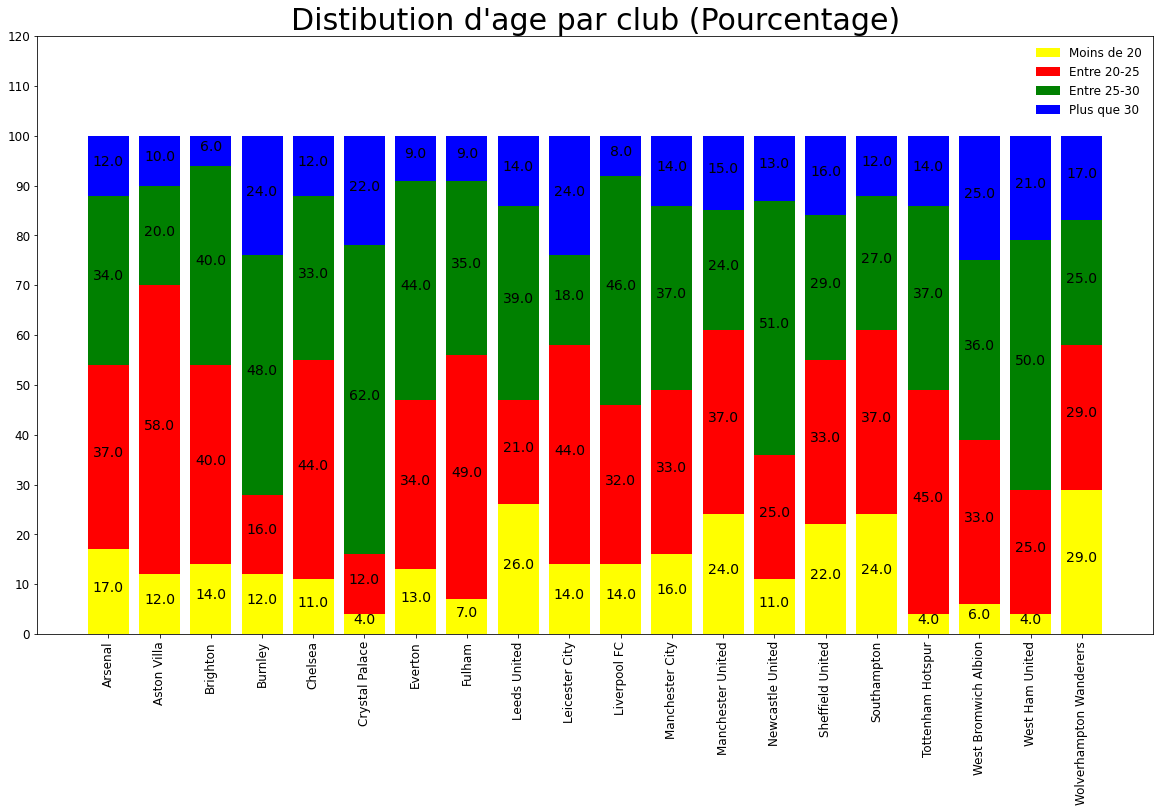

In [13]:
#Graphe de distibution d'age par club (pourcentages)
tot = epl_df[['Club','Age']].groupby('Club').count()['Age'] / 100
x1 = players_under_20[['Age', 'Club']].groupby('Club').count()['Age'] // tot
x2 = plyayers_between_20_25[['Age', 'Club']].groupby('Club').count()['Age'] // tot + x1
x3 = players_between_25_30[['Age', 'Club']].groupby('Club').count()['Age'] // tot + x2
x4 = 100 - x3 + x3
clubs = players_under_20[['Age', 'Club']].groupby('Club').count().index

fig, ax = plt.subplots(figsize=(20, 11))

ax.bar(clubs, x1, label = "Moins de 20", color='yellow')
ax.bar(clubs, x2 - x1,bottom= x1,label = "Entre 20-25", color='r')
ax.bar(clubs, x3 - x2,bottom= x2, label = "Entre 25-30",color='g')
ax.bar(clubs, x4 - x3,bottom= x3,label = "Plus que 30", color='b')

plt.xticks(clubs,rotation = 90, fontsize=12)
plt.yticks(np.arange(0,121,10), fontsize=12)
plt.title('Distibution d\'age par club (Pourcentage)', fontsize = 30)

for index, data in enumerate(x1):
    plt.text(x=index , y=data/2 , s=f"{data}" , fontdict=dict(fontsize=14), horizontalalignment='center')
for index, data in enumerate(x2):
    plt.text(x=index , y= x1[index] + ((data -x1[index]) /2) , s=f"{data - x1[index]}" , fontdict=dict(fontsize=14), horizontalalignment='center')
for index, data in enumerate(x3):
    plt.text(x=index , y= x2[index] + ((data -x2[index]) /2) , s=f"{data -x2[index]}" , fontdict=dict(fontsize=14), horizontalalignment='center')
for index, data in enumerate(x4):
    plt.text(x=index , y= x3[index] + ((data -x3[index]) /2) , s=f"{data -x3[index]}" , fontdict=dict(fontsize=14), horizontalalignment='center')
ax.legend(fontsize=12, frameon=False)
plt.show()

In [14]:
#Moyenne de l'age pour chaque club
number_of_players = epl_df.groupby('Club').size()
data = (epl_df.groupby('Club')['Age'].sum())//number_of_players
data.sort_values(ascending=False)

Club
Crystal Palace             28
Burnley                    27
West Ham United            27
West Bromwich Albion       26
Newcastle United           26
Leicester City             25
Chelsea                    25
Tottenham Hotspur          25
Manchester City            25
Liverpool FC               25
Leeds United               25
Fulham                     25
Everton                    25
Aston Villa                24
Brighton                   24
Wolverhampton Wanderers    24
Sheffield United           24
Southampton                24
Arsenal                    24
Manchester United          23
dtype: int64

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

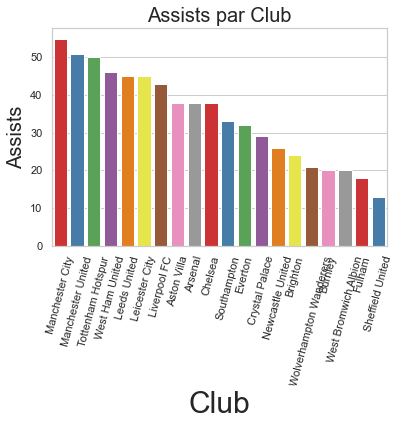

In [15]:
#Nombre de passes décisives par club
assists_by_club = pd.DataFrame(epl_df.groupby('Club', as_index=False)['Assists'].sum())
sns.set_theme(style="whitegrid", color_codes=True)
ax = sns.barplot(x='Club', y='Assists', data=assists_by_club.sort_values(by='Assists', ascending=False), palette='Set1')
ax.set_xlabel('Club', fontsize=30)
ax.set_ylabel('Assists', fontsize=20)
plt.xticks(rotation=75)
plt.title('Assists par Club', fontsize=20)
ax.bar_label(ax.containers[0])
plt.rcParams['figure.figsize'] = (20,8)
plt.show()

In [16]:
#Meilleur assisteurs
top_10_Assists = epl_df[['Name','Club','Assists','Matches']].nlargest(n=10,columns='Assists')
top_10_Assists

,Name,Club,Assists,Matches
162,Harry Kane,Tottenham Hotspur,14,35
34,Kevin De Bruyne,Manchester City,12,25
51,Bruno Fernandes,Manchester United,12,37
161,Son Heung-min,Tottenham Hotspur,10,37
273,Jack Grealish,Aston Villa,10,26
54,Marcus Rashford,Manchester United,9,37
110,Jamie Vardy,Leicester City,9,34
220,Raphael Dias Belloli,Leeds United,9,30
2,Timo Werner,Chelsea,8,35
136,Aaron Cresswell,West Ham United,8,36


AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

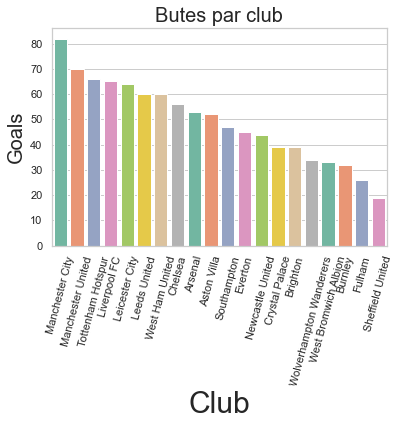

In [17]:
#Graphe des but par club
goals_by_club = pd.DataFrame(epl_df.groupby('Club', as_index=False)['Goals'].sum())
sns.set_theme(style="whitegrid", color_codes=True)
ax = sns.barplot(x='Club', y='Goals', data=goals_by_club.sort_values(by='Goals', ascending=False), palette='Set2')
ax.set_xlabel('Club', fontsize=30)
ax.set_ylabel('Goals', fontsize=20)
plt.xticks(rotation=75)
plt.rcParams['figure.figsize'] = (20,8)
plt.title('Butes par club', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [18]:
#Meilleurs Butteurs de la PL
top_10_Goals = epl_df[['Name','Club','Goals','Matches']].nlargest(n=10,columns='Goals')
top_10_Goals

,Name,Club,Goals,Matches
162,Harry Kane,Tottenham Hotspur,23,35
81,Mohamed Salah,Liverpool FC,22,37
51,Bruno Fernandes,Manchester United,18,37
161,Son Heung-min,Tottenham Hotspur,17,37
214,Patrick Bamford,Leeds United,17,38
237,Dominic Calvert-Lewin,Everton,16,33
110,Jamie Vardy,Leicester City,15,34
267,Ollie Watkins,Aston Villa,14,37
33,İlkay Gündoğan,Manchester City,13,28
191,Alexandre Lacazette,Arsenal,13,31


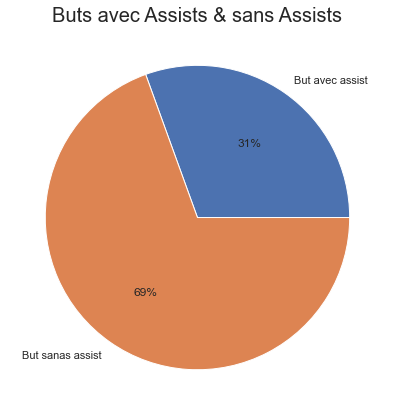

In [19]:
#Butes avec/sans assist
plt.figure(figsize=(14,7))
assists = epl_df['Assists'].sum()
goals = epl_df['Goals'].sum()
data = [goals-assists,assists]
labels = ['But avec assist','But sanas assist']
color = sns.color_palette()
plt.title('Buts avec Assists & sans Assists', fontsize = 20)
plt.pie(data, labels=labels, colors=color, autopct='%.0f%%')
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

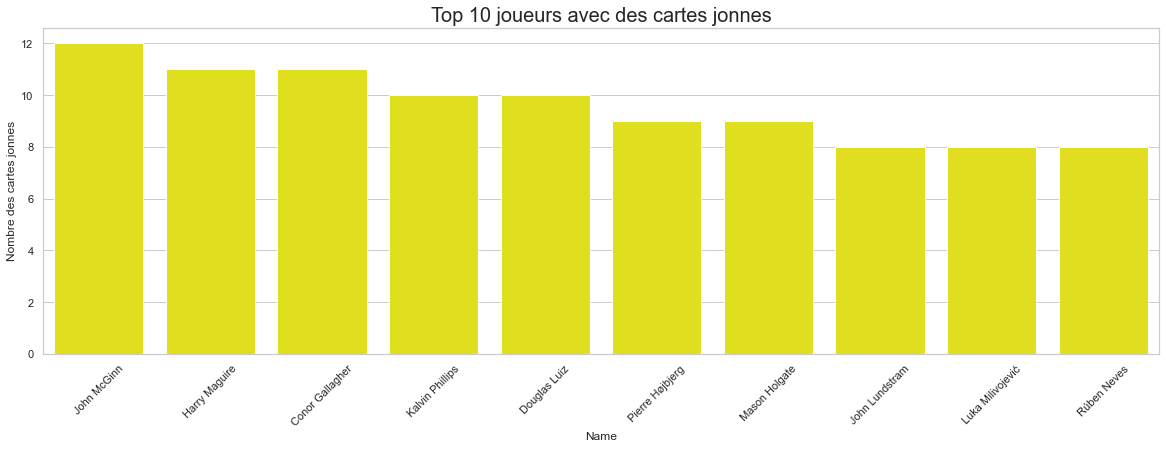

In [20]:
#Top 10 joueurs avec des cartes jonnes
top_10_players_with_yellow_cards = epl_df.sort_values(by='Yellow_Cards',ascending=False)[:10]
plt.figure(figsize=(20,6))
plt.title('Top 10 joueurs avec des cartes jonnes', fontsize = 20)
c = sns.barplot(x=top_10_players_with_yellow_cards['Name'], y=top_10_players_with_yellow_cards['Yellow_Cards'], label='Players', color='yellow')
plt.ylabel('Nombre des cartes jonnes')
c.set_xticklabels(c.get_xticklabels(), rotation=45)
c.bar_label(c.containers[0])
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

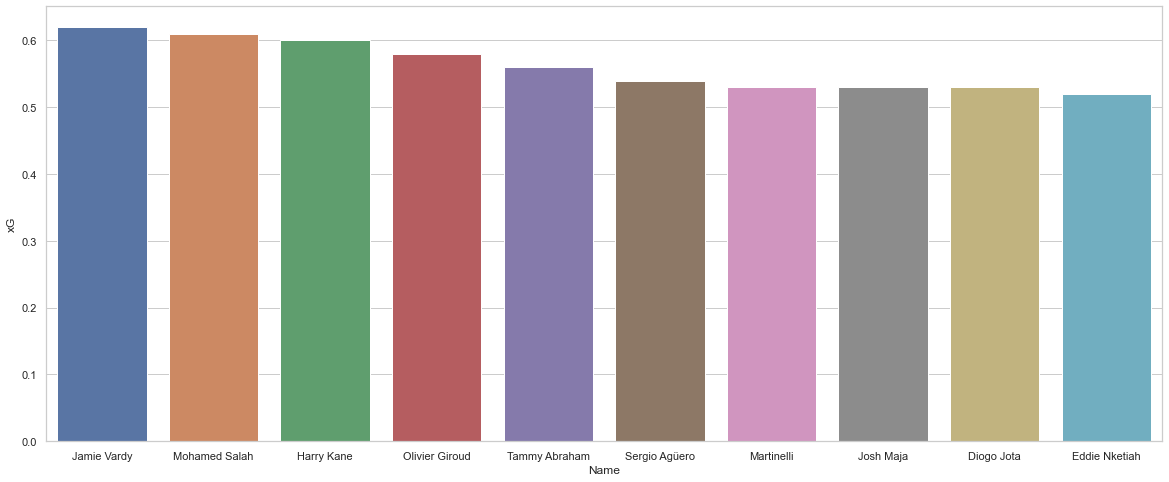

In [21]:
#Joueurs efficaces
df = epl_df[epl_df['Matches']>10].sort_values('xG',ascending=False)[['Name','xG','Goals','Club','Position']].head(10)
ax = sns.barplot(x="Name", y="xG", data=df)
ax.bar_label(ax.containers[0])
plt.title('Top 10 joueurs efficaces', fontsize = 20)
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

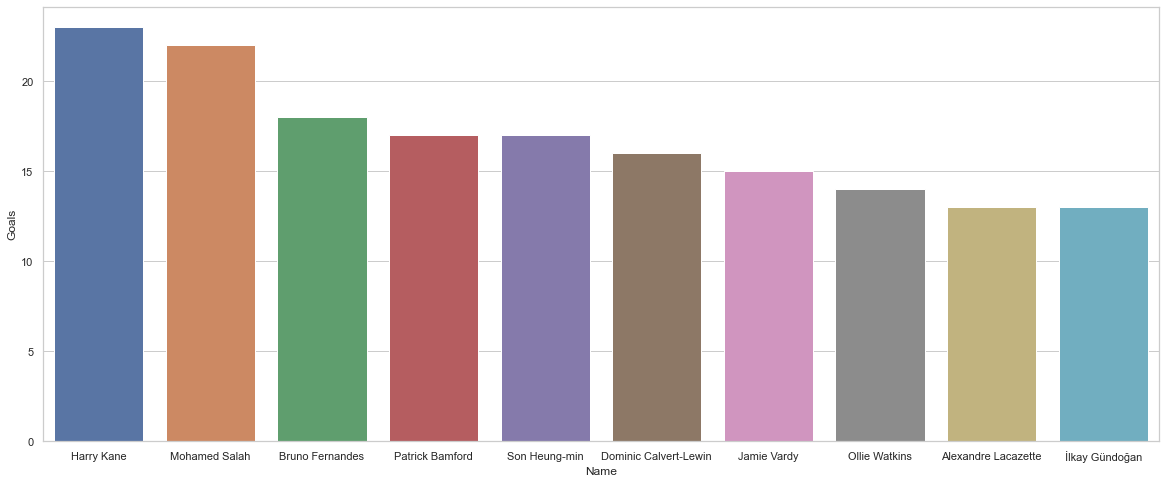

In [22]:
#Meileurs butteurs
df = epl_df[epl_df['Matches']>10].sort_values('Goals',ascending=False)[['Name','xG','Goals','Club','Position']].head(10)
ax = sns.barplot(x="Name", y="Goals", data=df)
ax.bar_label(ax.containers[0])
plt.title('Top 10 buteurs', fontsize = 20)
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

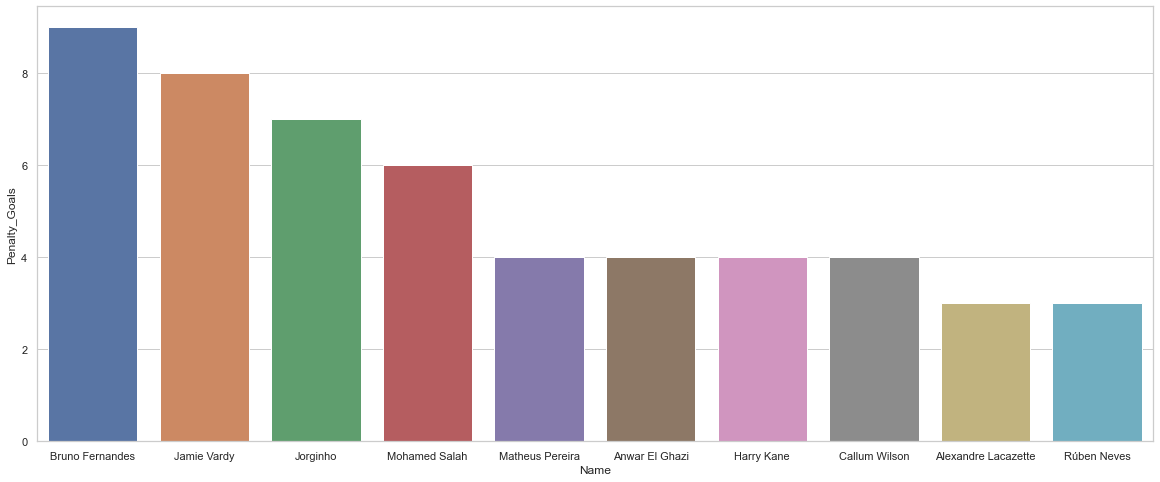

In [23]:
df = epl_df[epl_df['Penalty_Goals']>0].sort_values('Penalty_Goals',ascending=False)[['Name','Penalty_Attempted','Penalty_Goals','Club','Position']].head(10)
ax = sns.barplot(x="Name", y="Penalty_Goals", data=df)
ax.bar_label(ax.containers[0])
plt.show()

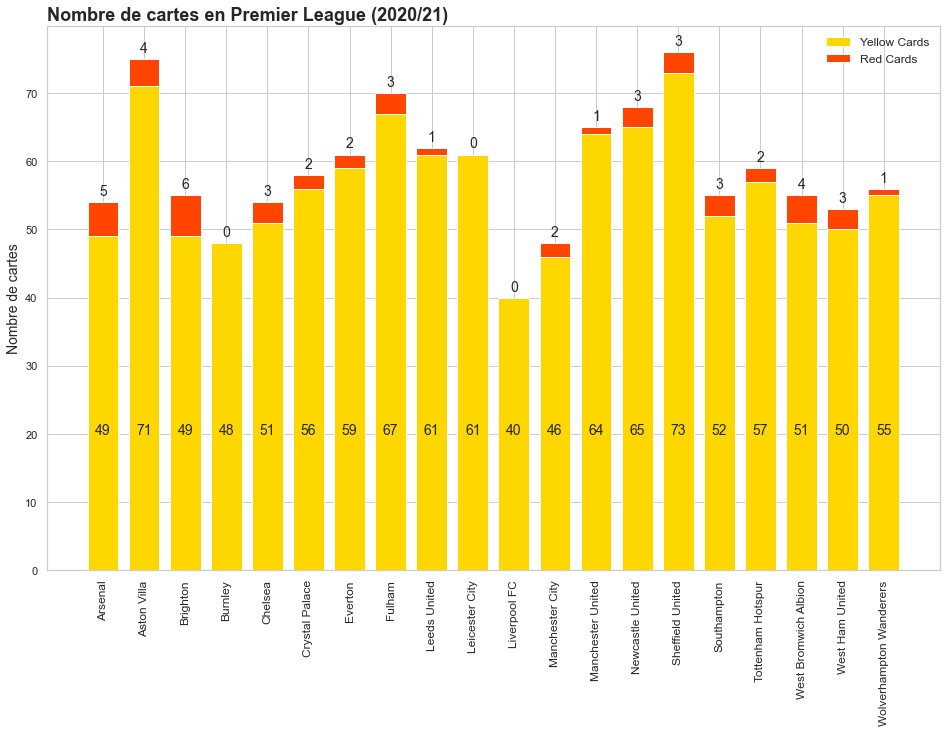

In [24]:
#Nombre de cartes par club
redyello = epl_df[['Club','Red_Cards','Yellow_Cards']]
df_1 = redyello.groupby('Club', as_index=False).agg({"Red_Cards": "sum", "Yellow_Cards": "sum"})
countries = df_1["Club"]
red_cards = df_1['Red_Cards']
yellow_cards = df_1['Yellow_Cards']

width = 0.75
fig, ax = plt.subplots(figsize=(16, 10))

ax.bar(countries, yellow_cards, width, label='Yellow Cards', color='gold')
ax.bar(countries, red_cards, width, bottom=yellow_cards, label='Red Cards', color='orangered')

ax.set_ylabel('Nombre de cartes', fontsize=14)
ax.set_title('Nombre de cartes en Premier League (2020/21)', loc='left', fontsize=18, fontweight ='bold')
plt.xticks(countries, rotation=90, fontsize=12)

for index, data in enumerate(red_cards):
    plt.text(x=index , y=data + yellow_cards[index] + 1 , s=f"{data}" , fontdict=dict(fontsize=14), horizontalalignment='center')

for index, data in enumerate(yellow_cards):
    plt.text(x=index , y=20 , s=f"{data}" , fontdict=dict(fontsize=14), horizontalalignment='center')

ax.legend(fontsize=12, frameon=False)

plt.show()

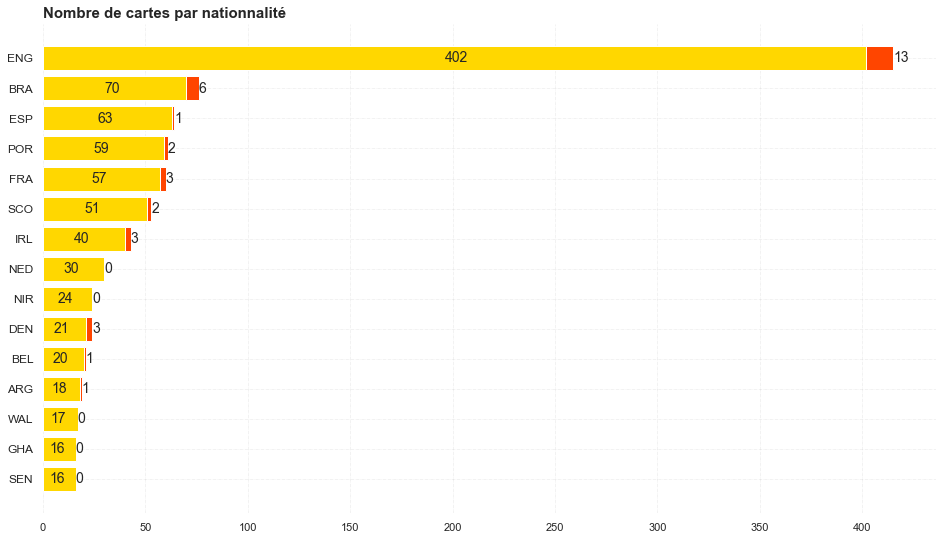

In [25]:
#Nombre de cartes par nationnalité
df_2 = epl_df[['Name','Nationality','Yellow_Cards','Red_Cards']].groupby('Nationality').agg({'Yellow_Cards':'sum', 'Red_Cards':'sum','Name':'count'}).sort_values(by=['Yellow_Cards', 'Red_Cards'], ascending=False).head(15)
df_2.rename(columns={'Name':'#_Players'}, inplace=True)

countries = df_2.index
red_cards = df_2['Red_Cards']
yellow_cards = df_2['Yellow_Cards']

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(countries, yellow_cards, color='gold')
ax.barh(countries, red_cards, left=yellow_cards, color='orangered')
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
x_red = red_cards.tolist()
y_yellow = yellow_cards.tolist()
for index, data in enumerate(x_red):
    plt.text(x=data + y_yellow[index], y=index , s=f"{data}" , fontdict=dict(fontsize=14), verticalalignment='center')
for index, data in enumerate(y_yellow):
    plt.text(x=data /2 - 5, y=index, s=f"{data}" , fontdict=dict(fontsize=14), verticalalignment='center')
ax.set_title('Nombre de cartes par nationnalité',
             loc ='left', size=15, fontweight ='bold' )
plt.yticks(fontsize=12)
plt.show()

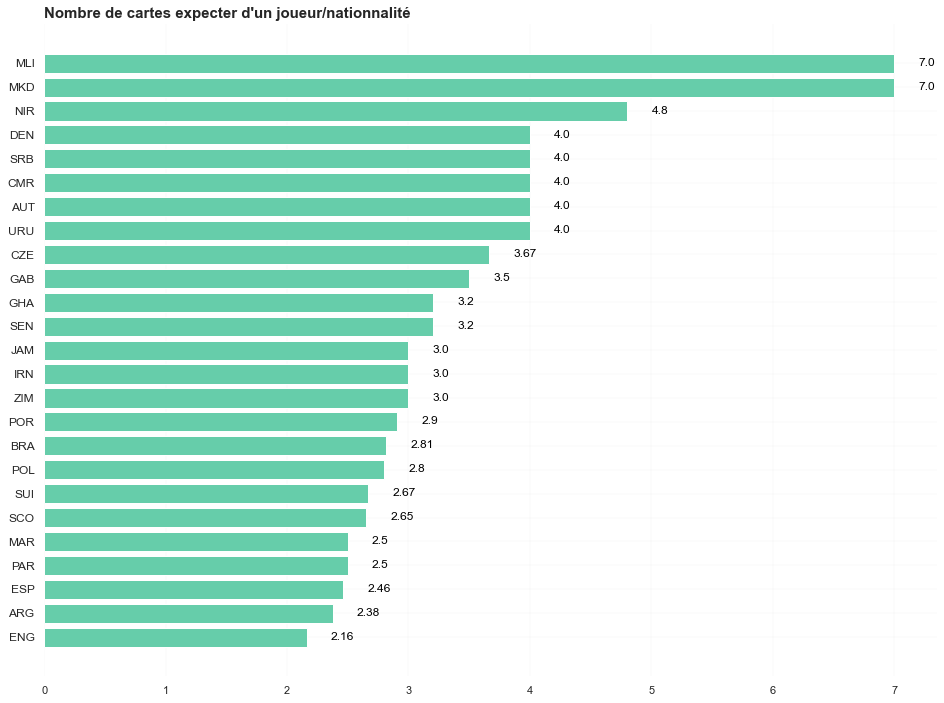

In [26]:
#Nombre de carte expecter de un joueur/nationnalité
cards_per_nation = epl_df[['Name', 'Nationality', 'Yellow_Cards', 'Red_Cards']].groupby('Nationality').agg({'Yellow_Cards':'sum', 'Red_Cards':'sum', 'Name':'count'})
cards_per_nation['Total_Cards'] = cards_per_nation.Yellow_Cards + cards_per_nation.Red_Cards
cards_per_nation.rename(columns={'Name':'#_Players'}, inplace=True)
cards_per_nation['Cards_per_Player'] = cards_per_nation['Total_Cards'] / cards_per_nation['#_Players']
cards_per_nation = cards_per_nation.sort_values(by=['Cards_per_Player', '#_Players'], ascending=False).reset_index().head(25)
countries = cards_per_nation['Nationality']
cards = cards_per_nation['Cards_per_Player']
fig, ax = plt.subplots(figsize =(16, 12))
ax.barh(countries, cards, color='mediumaquamarine')
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.grid(b = True, color ='grey',
        linestyle ='-', linewidth = 0.2,
        alpha = 0.2)
ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=12,
             color='black')

ax.set_title('Nombre de cartes expecter d\'un joueur/nationnalité',
             loc='left', size=15, fontweight='bold')
plt.yticks(fontsize=12)
plt.show()

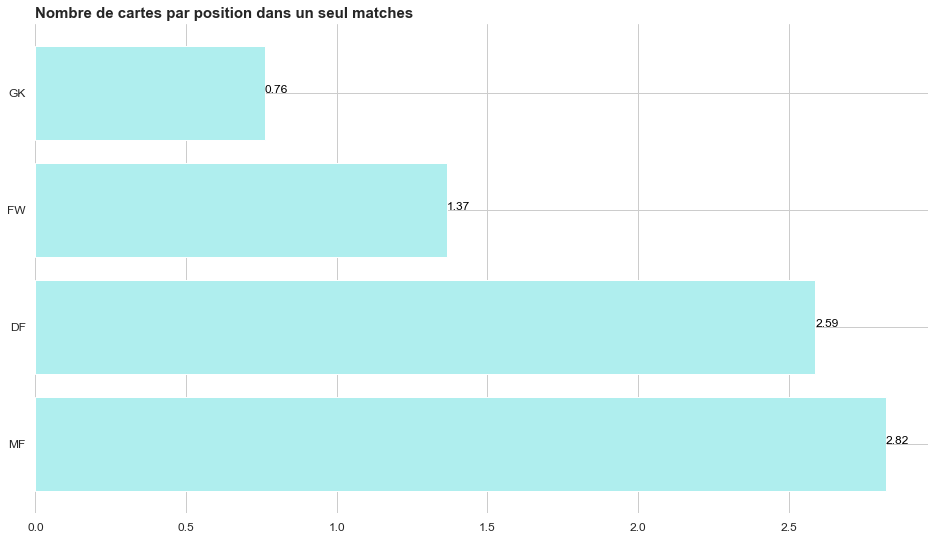

In [27]:
#Nombre de cartes par position de jeux
cards_per_position = epl_df[['Name','Position', 'Yellow_Cards', 'Red_Cards']].groupby('Position').agg({'Yellow_Cards':'sum', 'Red_Cards':'sum', 'Name':'count'}).reset_index()
cards_per_position['Total_Cards'] = cards_per_position.Yellow_Cards + cards_per_position.Red_Cards
cards_per_position.rename(columns={'Name':'#_Players'}, inplace=True)
cards_per_position['Cards_per_Position'] = cards_per_position['Total_Cards'] / cards_per_position['#_Players']
cards_per_position = cards_per_position.reset_index(drop=True).sort_values(by=['Cards_per_Position', '#_Players'],ascending=False)
positions = cards_per_position['Position']
cards = cards_per_position['Cards_per_Position']

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(positions, cards, color='paleturquoise')

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.4,
             str(round((i.get_width()), 2)),
             fontsize = 12,
             color ='black') 
# fontweight ='bold'
ax.set_title('Nombre de cartes par position dans un seul matches',
             loc ='left', size=15, fontweight ='bold' )

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

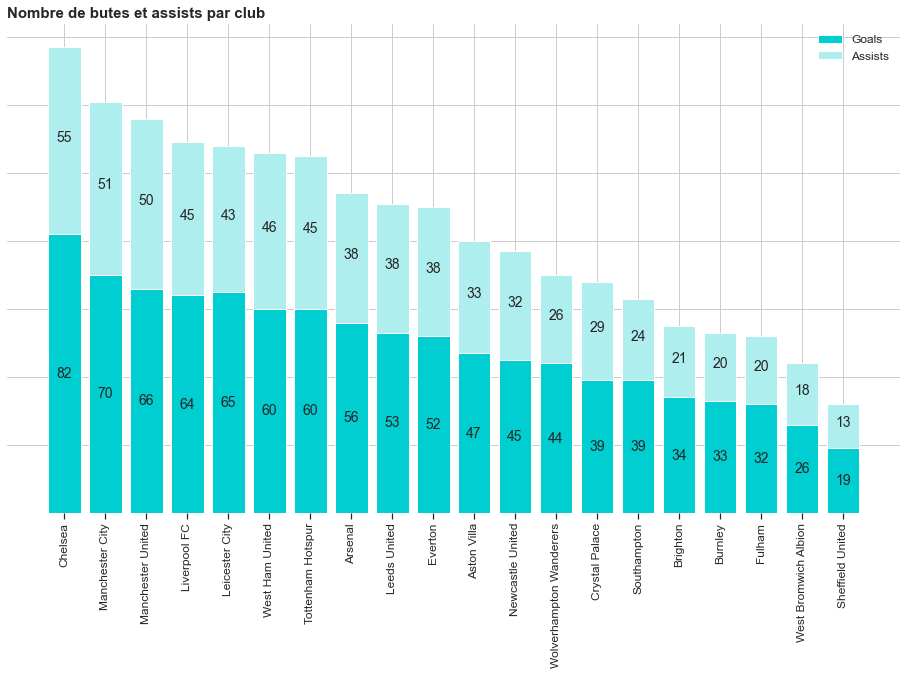

In [28]:
#Butes et assists par club
df_goals = epl_df.copy()
df_goals['xGoals'] = round(df_goals.xG * df_goals.Matches,0).astype(int)
df_goals['xG_diff'] =  (df_goals.Goals - df_goals.xGoals).astype(int)
df_goals = df_goals[['Name', 'Club', 'Nationality', 'Position', 'Goals', 'xGoals', 'xG_diff', 'Assists']].groupby('Club').sum()
df_goals['Canadian_Points'] = df_goals.Goals + df_goals.Assists
df_goals = df_goals.sort_values(by='Canadian_Points', ascending=False) 
df_goals
goals = df_goals['Goals']
assists = df_goals['Assists']
clubs = epl_df['Club'].unique()
fig, ax = plt.subplots(figsize =(16, 9))
ax.bar(clubs, goals, label="Goals", color='darkturquoise')
ax.bar(clubs, assists, bottom=goals, label="Assists", color='paleturquoise')
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
x_goals = goals.tolist()
x_assists = assists.tolist()
for ia, da in enumerate(x_assists):
    plt.text(x=ia, y=da / 2 + x_goals[ia] + 1, s=f"{da}", fontdict=dict(fontsize=14), horizontalalignment='center', verticalalignment='center')
for ig, dg in enumerate(x_goals):
    plt.text(x=ig, y=dg / 2, s=f"{dg}", fontdict=dict(fontsize=14), horizontalalignment='center', verticalalignment='center')
ax.set_title('Nombre de butes et assists par club',
             loc='left', size=15, fontweight='bold')
ax.legend(fontsize=12, frameon=False)
plt.tick_params(left = False, right = False, labelleft=False, labelbottom=True, bottom=True)
plt.xticks(clubs,rotation=90,fontsize=12)
plt.show()

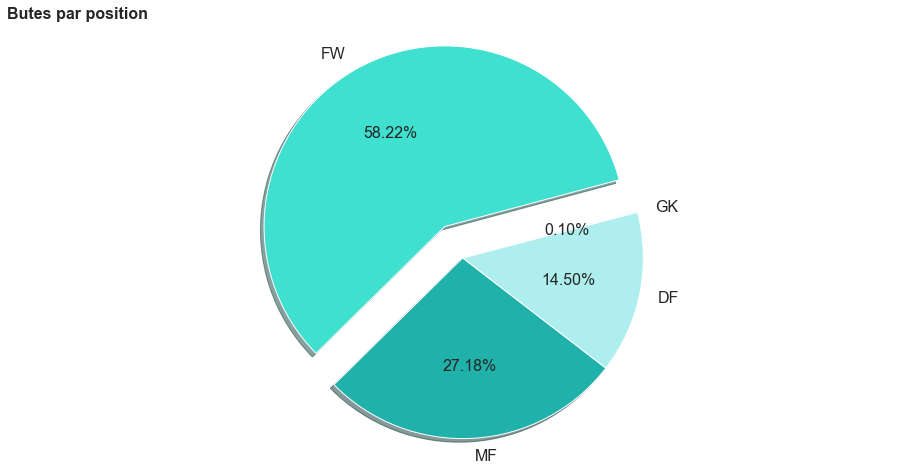

In [29]:
#Pourcentages des butes par position
# variables
my_labels = epl_df[['Position','Goals']].groupby(['Position']).sum().sort_values(by=['Goals'],ascending=False).head(10).index.tolist()
my_colors = ['turquoise','lightseagreen','paleturquoise','darkturquoise']
myexplode = [0.2, 0, 0, 0]
# plot
epl_df[['Position','Goals']].groupby(['Position']).sum().sort_values(by=['Goals'],ascending=False).head(10)\
        .plot(x='Name',kind='pie', figsize=(16,8), subplots=True, labels=my_labels,startangle=15, 
        shadow=True, colors=my_colors, explode=myexplode, autopct='%1.2f%%', fontsize=16)
plt.title('Butes par position', loc ='left', size=16, fontweight ='bold')
plt.ylabel(None)
plt.axis('equal')
plt.legend([],frameon=False)
plt.show()

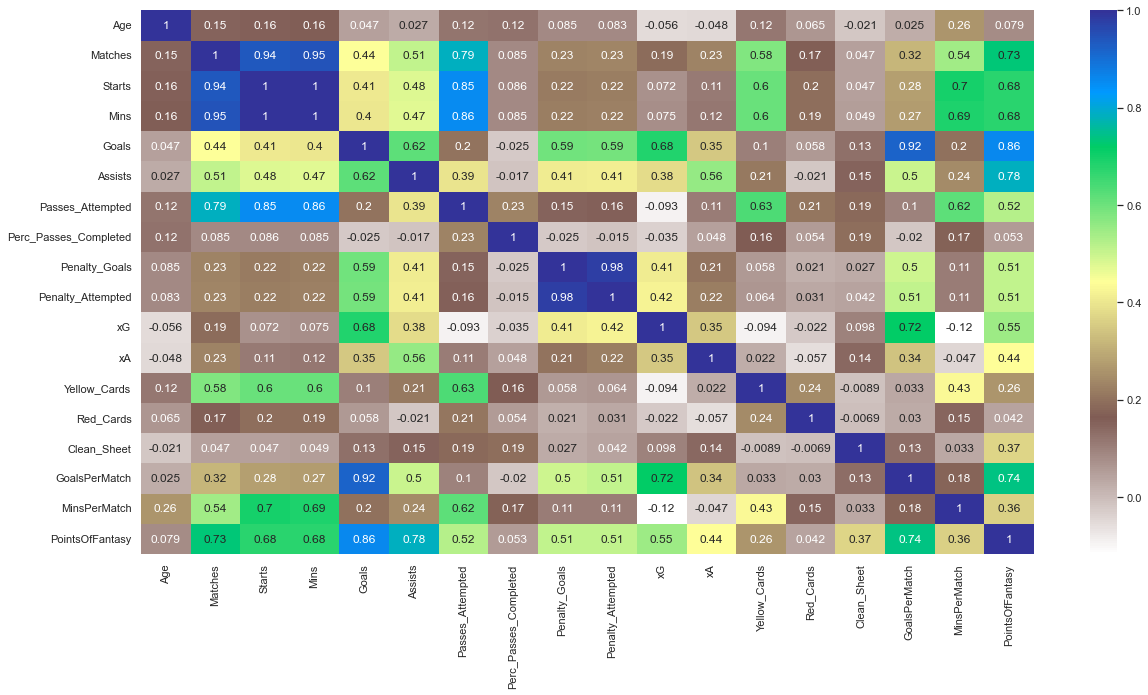

In [31]:
#Matrice de correlation----------------------------------------------
corr_matrix = epl_df.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.terrain_r)
plt.show()

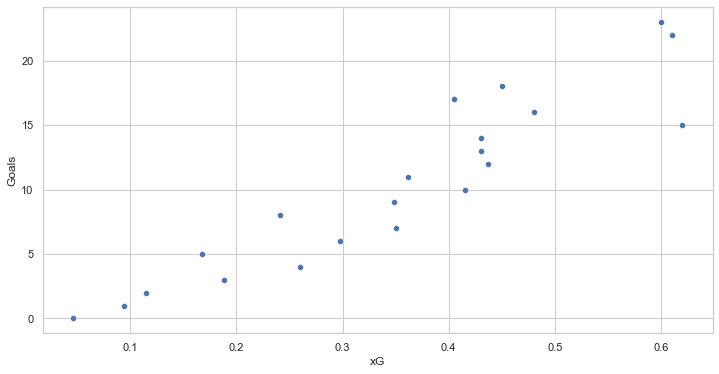

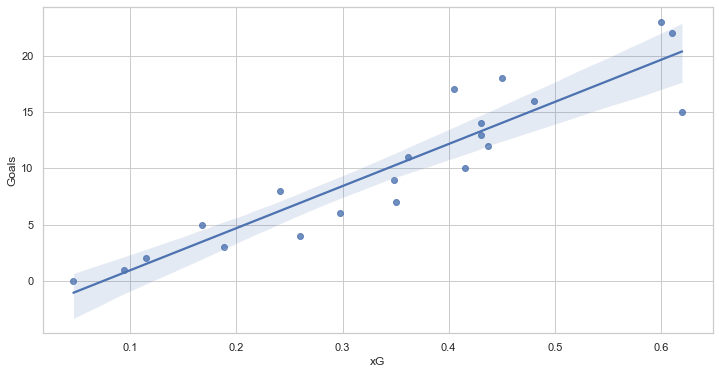

In [36]:
#Regression Lineaire entre les butes et les butes expectée
df = epl_df[['Goals','xG']].groupby('Goals', as_index=False).mean()
plt.figure(figsize=(12,6))
sns.scatterplot(x="xG", y="Goals", data=df)
plt.show()
plt.figure(figsize=(12,6))
sns.regplot(x="xG", y="Goals", data=df)

plt.show()

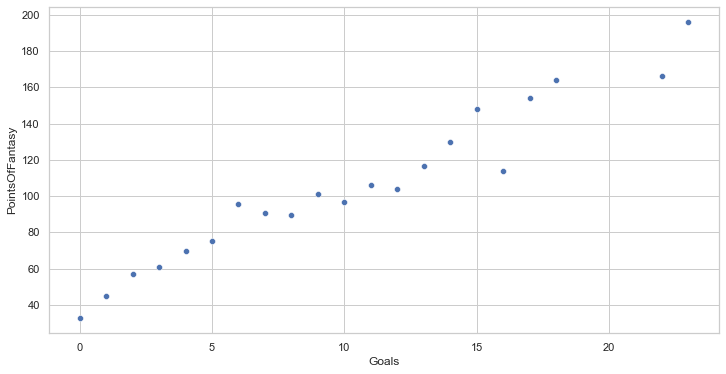

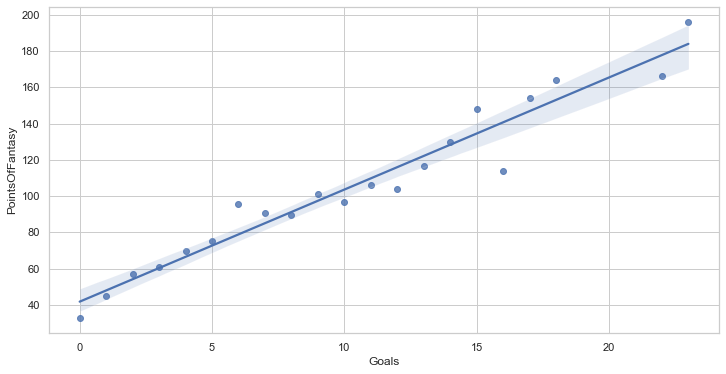

In [39]:
#Regression Lineaire entre les butes et les points de performance par joueur
df = epl_df[['Goals','PointsOfFantasy']].groupby('Goals', as_index = False).mean()
plt.figure(figsize=(12,6))
sns.scatterplot(x="Goals", y="PointsOfFantasy", data=df)
plt.show()
plt.figure(figsize=(12,6))
sns.regplot(x="Goals", y="PointsOfFantasy", data=df)
plt.show()

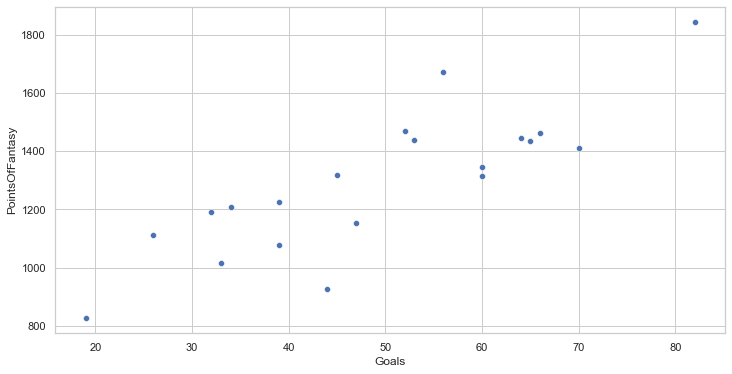

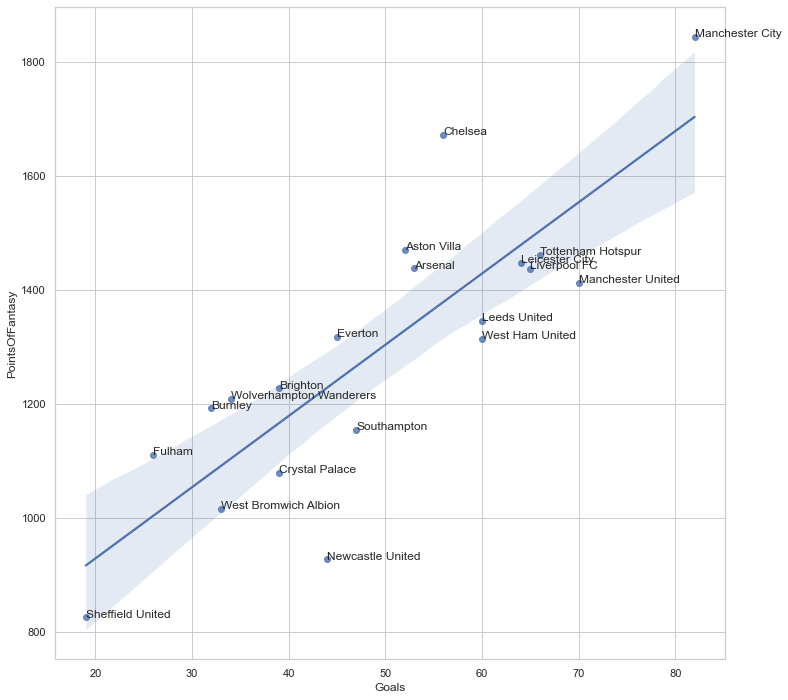

In [42]:
#Regression Lineaire entre les butes et les points de performance par club
df = epl_df[["Club","Goals","PointsOfFantasy"]].groupby("Club").sum()
plt.figure(figsize=(12,6))
sns.scatterplot(x="Goals", y="PointsOfFantasy", data=df)
plt.show()
plt.figure(figsize=(12,12))
x = df["Goals"]
y = df["PointsOfFantasy"]
sns.regplot(x="Goals", y="PointsOfFantasy", data=df)
for i in range(20):
    plt.annotate(df.index[i],(x[i],y[i]))
plt.show()

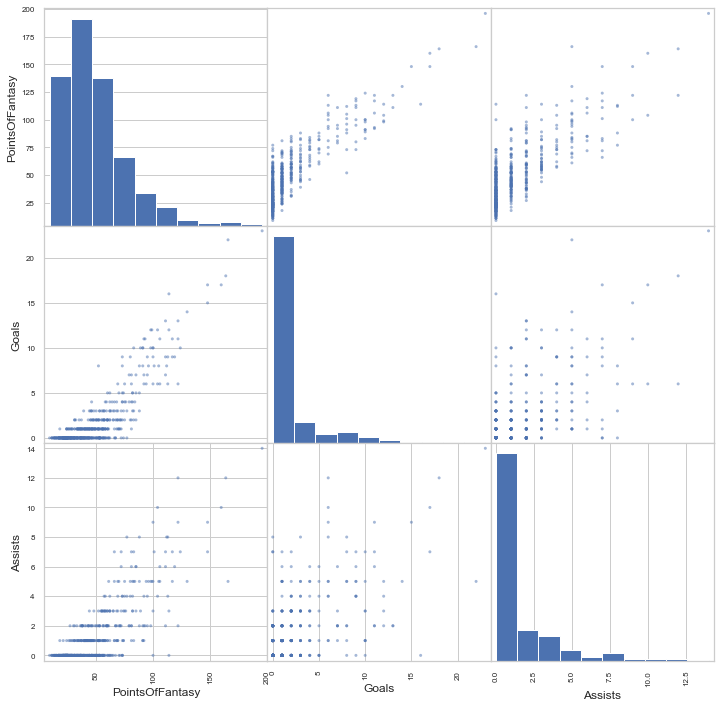

In [474]:
#Regresion multiple butes / assists / Points de performance
colors = epl_df['Performance_Cat'].astype('category')
# Les couleurs déduites de chaque categorie de performance
y = colors.cat.codes 
rg_mu = epl_df[["PointsOfFantasy","Goals","Assists"]]
scatter_matrix(rg_mu,alpha = 0.5,figsize=(12,12),range_padding=0.05)
plt.show()

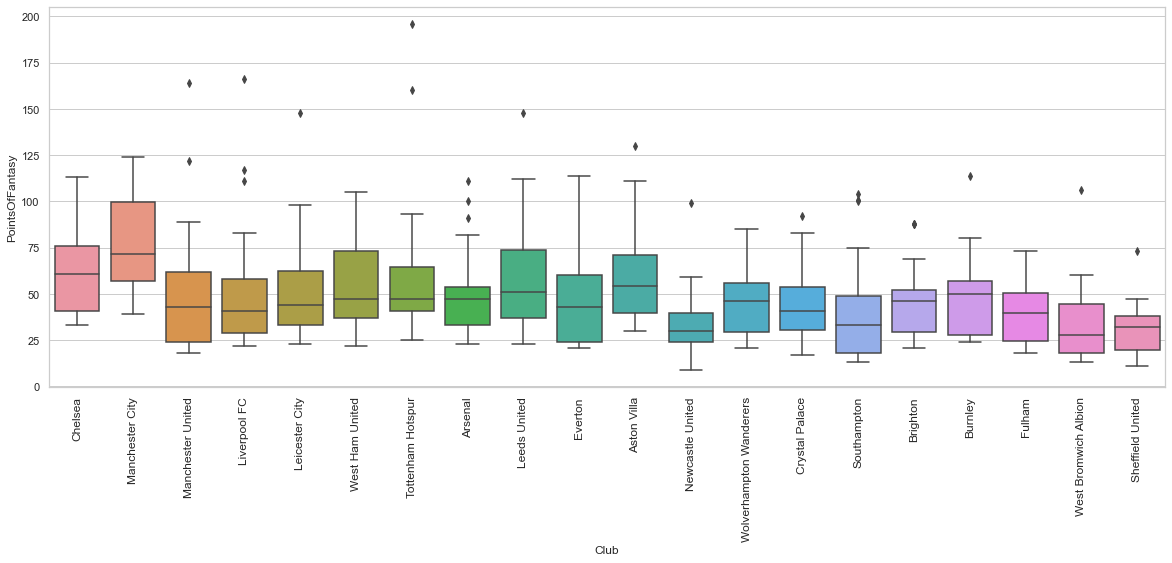

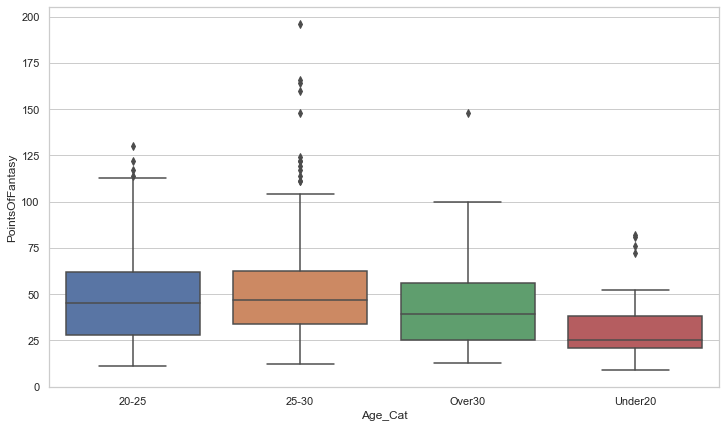

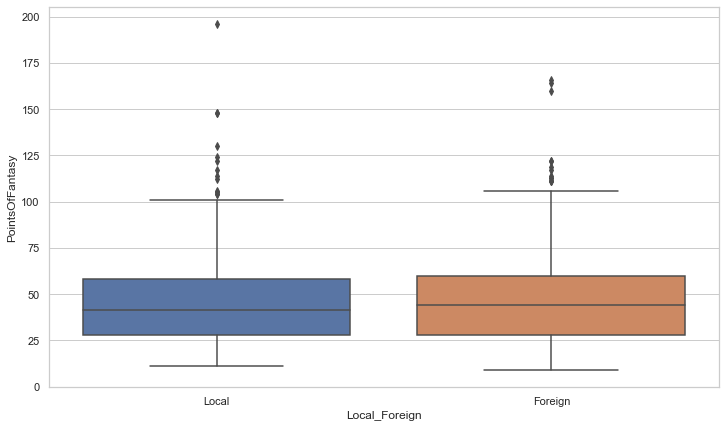

In [482]:
#ANOVA
#Boite a moustache 1 variable
plt.figure(figsize=(20,7))
sns.boxplot(x = 'Club', y = 'PointsOfFantasy', data = epl_df)
plt.xticks(rotation=90, fontsize=12)
plt.show()
#Boite a moustache deux variables
#Effet de l'age
plt.figure(figsize=(12,7))
sns.boxplot(x = 'Age_Cat', y = 'PointsOfFantasy', data = epl_df)
plt.show()
#effet de nationnalité
plt.figure(figsize=(12,7))
sns.boxplot(x = 'Local_Foreign', y = 'PointsOfFantasy', data = epl_df)
plt.show()

In [57]:
#application de ANOVA1
model = ols('PointsOfFantasy ~ C(Club)', data=epl_df).fit()
print(sm.stats.anova_lm(model, typ=1))
#Application ANOVA2
model = ols('PointsOfFantasy ~ C(Local_Foreign) + C(Age_Cat) + C(Local_Foreign):C(Age_Cat)', data=epl_df).fit()
sm.stats.anova_lm(model, typ=2)

             df         sum_sq      mean_sq         F        PR(>F)
C(Club)    19.0   62169.150925  3272.060575  5.033494  4.765514e-11
Residual  512.0  332829.426143   650.057473       NaN           NaN


,sum_sq,df,F,PR(>F)
C(Local_Foreign),432.570694,1.0,0.607284,0.436164
C(Age_Cat),21534.981297,3.0,10.077622,0.000002
C(Local_Foreign):C(Age_Cat),215.055315,3.0,0.100638,0.959630
Residual,373247.105239,524.0,NaN,NaN


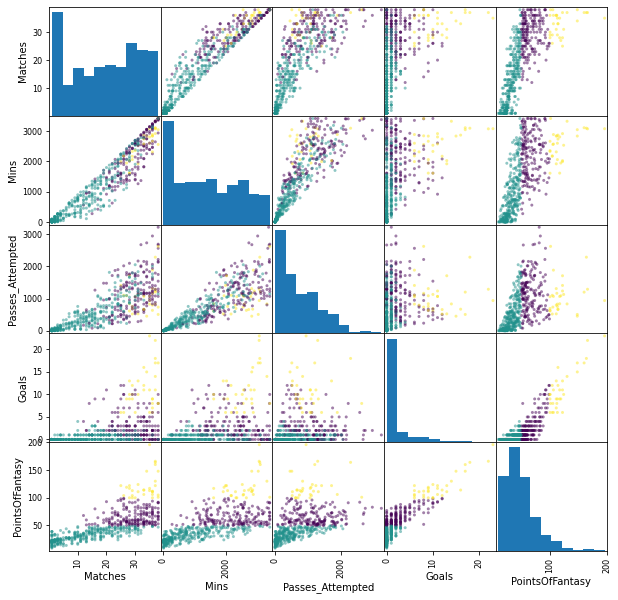

In [138]:
#ACP - Affichage des nuages des points par couples de variables :
acp_df = epl_df[['Matches','Mins','Passes_Attempted','Goals','PointsOfFantasy']]
colors = epl_df['Performance_Cat'].astype('category')
# Les couleurs déduites de chaque categorie de performance
y = colors.cat.codes 
scatter_matrix(acp_df,alpha = 0.5,figsize=(10,10),range_padding=0.05,c=y)
plt.show()

In [139]:
#Centralisation et reduction des donnees
X= acp_df
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X) 
from sklearn.preprocessing import scale
X = scale(X)

In [488]:
#Definition de l'acp
mypca = PCA(n_components = 3) # On paramètre ici pour ne garder que 3 composantes
# Modèle d'ACP
mypca.fit(X)
# Pourcentage de la variance expliquée par chacune des composantes sélectionnées.
print('\nPourcentage de la variance expliquée par chacune des composantes sélectionnées.')
print(mypca.singular_values_) # Valeurs de variance
print(mypca.explained_variance_ratio_) #  Pourcentages
# Axes principaux dans l'espace des caractéristiques, représentant les directions de la variance maximale dans les données. Les composantes sont triées par variance expliquée.
print(" \nAxes principaux dans l'espace des caractéristiques, représentant les directions de la variance maximale dans les données. Les composantes sont triées par variance expliquée.")
print(mypca.components_)
# Résultats de l'ACP
print(" \nRésultats de l'ACP")
data_sortie= mypca.fit_transform(X)
data_sortie


Pourcentage de la variance expliquée par chacune des composantes sélectionnées.
[43.85675772 24.00654699 10.02666682]
[0.72308842 0.21665951 0.03779475]
 
Axes principaux dans l'espace des caractéristiques, représentant les directions de la variance maximale dans les données. Les composantes sont triées par variance expliquée.
[[ 0.49359883  0.49107811  0.42750091  0.34366901  0.46296551]
 [-0.19780776 -0.27911358 -0.46304852  0.70803843  0.40894418]
 [-0.57424087 -0.27608543  0.74697237  0.16608348  0.09204794]]
 
Résultats de l'ACP


array([[ 3.57318349,  0.2153274 ,  0.58672814],
       [ 1.32099333, -0.96987632, -0.61796416],
       [ 2.79967501,  1.18870061, -0.51412543],
       ...,
       [-2.74856363,  0.25034214,  0.20449833],
       [-2.7503903 ,  0.25207813,  0.20239483],
       [-2.75578001,  0.25549037,  0.20385971]])

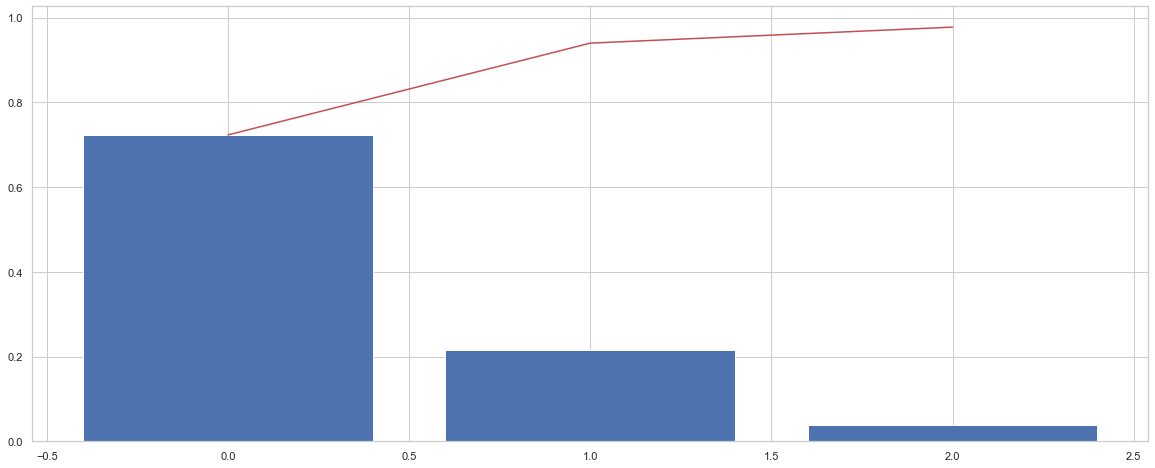

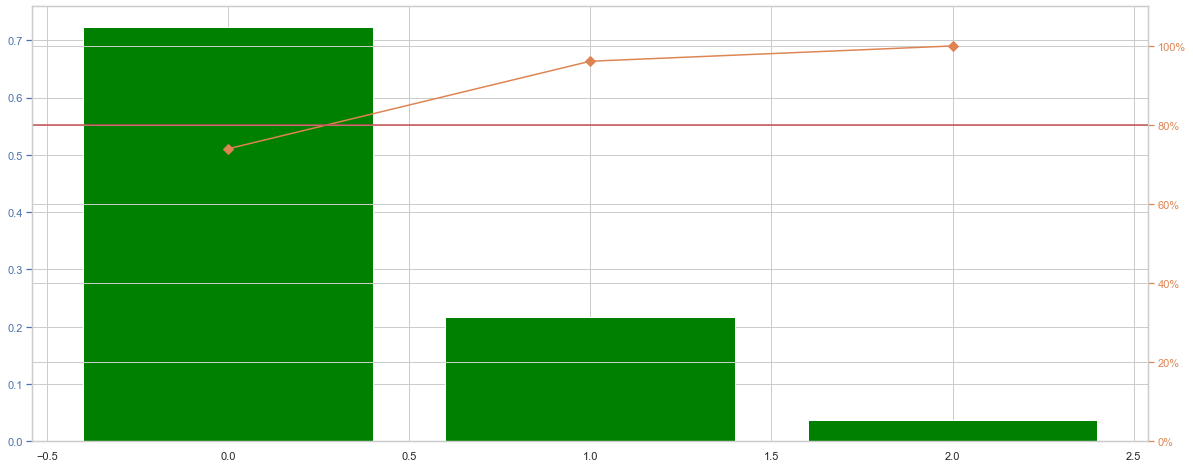

In [491]:
#Niveau de representation de chaque composant
y = list(mypca.explained_variance_ratio_)
x = range(len(y))
ycum = np.cumsum(y)
plt.bar(x,y)
plt.plot(x,ycum,"-r")
plt.show()


def pareto(data) :
    from matplotlib.ticker import PercentFormatter
    import numpy as np
    y = list(data)
    x = range(len(data))
    ycum = np.cumsum(y)/sum(y)*100
    fig, ax = plt.subplots()
    ax.bar(x,y,color="Green")
    ax2 = ax.twinx()
    ax2.plot(x,ycum, color="C1", marker="D", ms=7)
    ax2.axhline(y=80,color="r")
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.tick_params(axis="y", colors="C0")
    ax2.tick_params(axis="y", colors="C1")
    plt.ylim(0,110)
    plt.show()
pareto(mypca.explained_variance_ratio_)
plt.show()

In [492]:
#Mothode de decin du cercle avec les points et les variables
from scipy.spatial import ConvexHull
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
from sklearn.decomposition import PCA
def biplot(pca=[],x=None,y=None,components=[0,1],score=None,coeff=None,coeff_labels=None,score_labels=None,circle='T',bigdata=1000,cat=None,cmap="viridis",density=True):
    if isinstance(pca,PCA)==True :
        coeff = np.transpose(pca.components_[components, :])
        score=  pca.fit_transform(x)[:,components]
        if isinstance(x,pd.DataFrame)==True :
            coeff_labels = list(x.columns)
    if score is not None : x = score
    if x.shape[1]>1 :
        xs = x[:,0]
        ys = x[:,1]
    else :
        xs = x
        ys = y
    if (len(xs) != len(ys)) : print("Warning ! x et y n'ont pas la même taille !")
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    #x_c = xs * scalex
    #y_c = ys * scaley
    temp = (xs - xs.min())
    x_c = temp / temp.max() * 2 - 1
    temp = (ys - ys.min())
    y_c = temp / temp.max() * 2 - 1
    data = pd.DataFrame({"x_c":x_c,"y_c":y_c})
    print("Attention : pour des facilités d'affichage, les données sont centrées-réduites")
    if cat is None : cat = [0]*len(xs)
    elif len(pd.Series(cat)) == 1 : cat = list(pd.Series(cat))*len(xs)
    elif len(pd.Series(cat)) != len(xs) : print("Warning ! Nombre anormal de catégories !")
    cat = pd.Series(cat).astype("category")
    fig = plt.figure(figsize=(14,14),facecolor='w') 
    ax = fig.add_subplot(111)
    # Affichage des points
    if (len(xs) < bigdata) :   
        ax.scatter(x_c,y_c, c = cat.cat.codes,cmap=cmap)
        if density==True : print("Warning ! Le mode density actif n'apparait que si BigData est paramétré.")
    # Affichage des nappes convexes (BigData)
    else :
        #color
        norm = mpl.colors.Normalize(vmin=0, vmax=(len(np.unique(cat.cat.codes)))) #-(len(np.unique(c)))
        cmap = cmap
        m = cm.ScalarMappable(norm=norm, cmap=cmap)
        if density==True :
            sns.set_style("white")
            sns.kdeplot(x="x_c",y="y_c",data=data)
            if len(np.unique(cat)) <= 1 :
                sns.kdeplot(x="x_c",y="y_c",data=data, cmap="Blues", shade=True, thresh= 0)
            else :
                for i in np.unique(cat) :
                    color_temp = m.to_rgba(i)
                    sns.kdeplot(x="x_c",y="y_c",data=data[cat==i], color=color_temp,
                                shade=True, thres=0.25, alpha=0.25)     
        for cat_temp in cat.cat.codes.unique():
            x_c_temp = [x_c[i] for i in range(len(x_c)) if (cat.cat.codes[i] == cat_temp)]
            y_c_temp = [y_c[i] for i in range(len(y_c)) if (cat.cat.codes[i] == cat_temp)]
            points = [ [ None ] * len(x_c_temp) ] * 2
            points = np.array(points)
            points = points.reshape(len(x_c_temp),2)
            points[:,0] = x_c_temp
            points[:,1] = y_c_temp
            hull = ConvexHull(points)
            temp = 0
            for simplex in hull.simplices:
                color_temp = m.to_rgba(cat_temp)
                plt.plot(points[simplex, 0], points[simplex, 1],color=color_temp)#, linestyle='dashed')#linewidth=2,color=cat)
                if (temp == 0) :
                     plt.xlim(-1,1)
                     plt.ylim(-1,1)
                     temp = temp+1
    if coeff is not None :
        if (circle == 'T') :
            x_circle = np.linspace(-1, 1, 100)
            y_circle = np.linspace(-1, 1, 100)
            X, Y = np.meshgrid(x_circle,y_circle)
            F = X**2 + Y**2 - 1.0
            #fig, ax = plt.subplots()
            plt.contour(X,Y,F,[0])
        n = coeff.shape[0]
        for i in range(n):
            plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5,
                      head_width=0.05, head_length=0.05)
            if coeff_labels is None:
                plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
            else:
                plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, coeff_labels[i], color = 'g', ha = 'center', va = 'center')
        if score_labels is not None :
            for i in range(len(score_labels)) :
                temp_x = xs[i] * scalex
                temp_y = ys[i] * scaley
                plt.text(temp_x,temp_y,list(score_labels)[i])
    plt.xlim(-1.2,1.2)
    plt.ylim(-1.2,1.2)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid(linestyle='--')
    plt.show()

Attention : pour des facilités d'affichage, les données sont centrées-réduites
Warning ! Le mode density actif n'apparait que si BigData est paramétré.


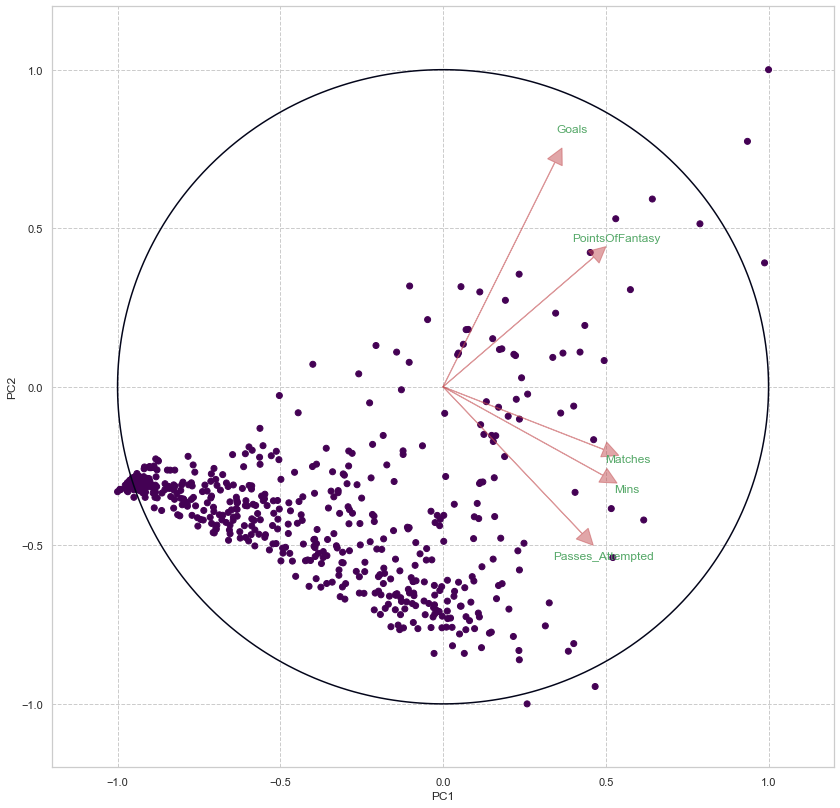

In [501]:
#Visualisation des variables
colors = epl_df['Performance_Cat'].astype('category')
y = colors.cat.codes 
biplot(mypca,x=X,components=[0,1],coeff_labels = acp_df.columns.values.tolist())
plt.show()

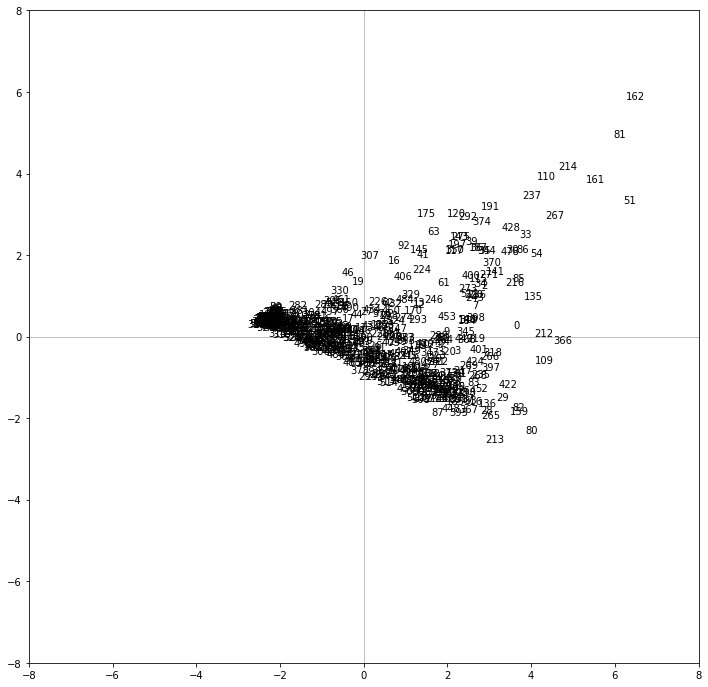

In [162]:
#positionnement des individus dans le premier plan
coord = mypca.fit_transform(X)
fig, axes = plt.subplots(figsize=(12,12))
axes.set_xlim(-8,8) #même limites en abscisse
axes.set_ylim(-8,8) #et en ordonnée
#placement des étiquettes des observations
for i in range(530):
    plt.annotate(acp_df.index[i],(coord[i,0],coord[i,1]))
#ajouter les axes
plt.plot([-8,8],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-8,8],color='silver',linestyle='-',linewidth=1)
#affichage
plt.show()

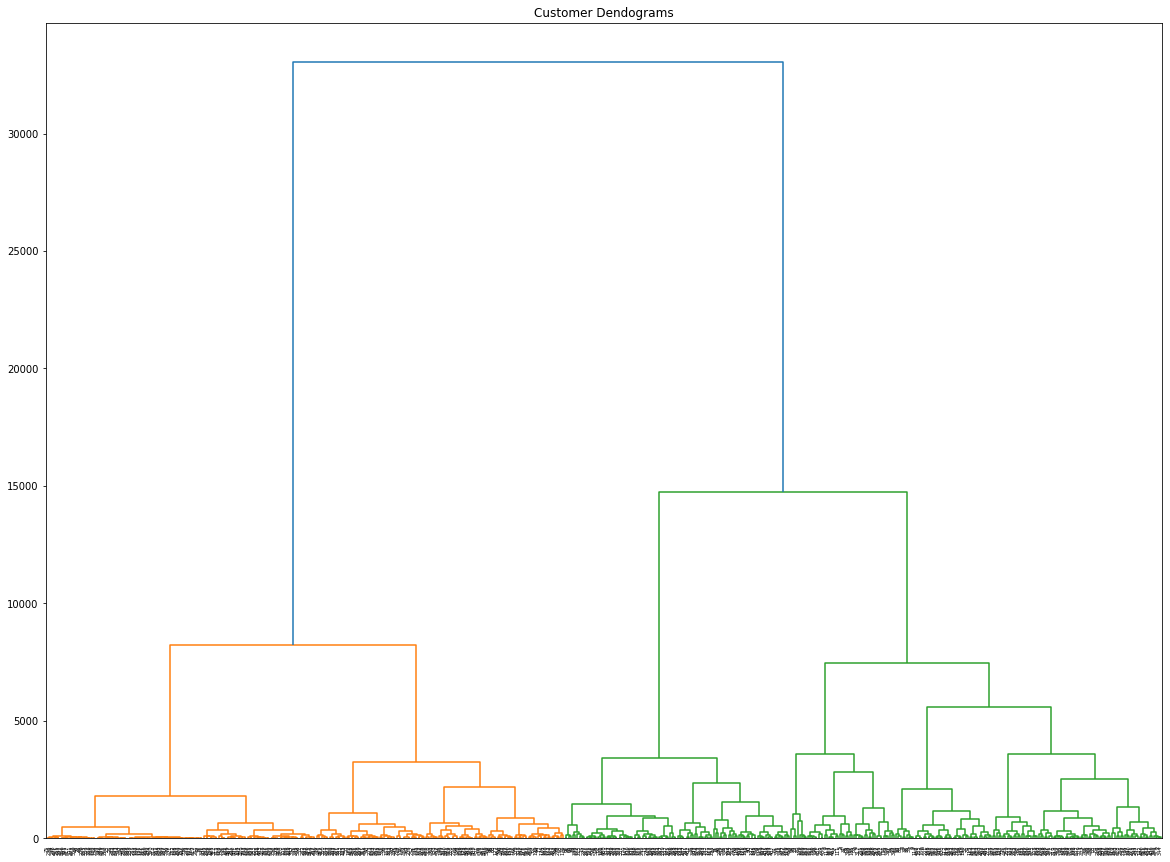

In [394]:
import scipy.cluster.hierarchy as shc

data = acp_df.iloc[:,:].values
plt.figure(figsize=(20, 15))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(data, method='ward'))

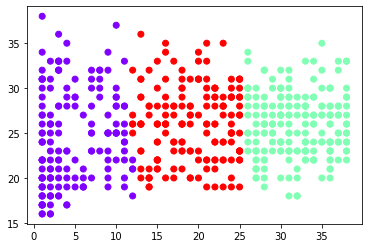

In [167]:
from sklearn.cluster import KMeans
x = epl_df.iloc[:, 4:6]
kmeans = KMeans(3)
kmeans.fit(x)
identified_clusters = kmeans.fit_predict(x)
identified_clusters
data_with_clusters = epl_df.copy()
data_with_clusters['Clusters'] = identified_clusters
plt.scatter(data_with_clusters['Matches'],data_with_clusters['Age'],c=data_with_clusters['Clusters'],cmap='rainbow')